In [21]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import models
from Constants import *
from Postprocessing import post_process

In [22]:
import midi

def data_to_midi(data, bpm=60):

    SCALER = 4 # Aribtrary value to round up the PPQN and not lose accuracy
    PPQN = FRAME_RATE*SCALER # Pulses per quarter note

    pattern = midi.Pattern(resolution=round(PPQN))
    track = midi.Track()
    tempo_event = midi.events.SetTempoEvent()
    tempo_event.set_bpm(bpm)
    track.append(tempo_event)

    note_array = np.zeros(N_NOTES, dtype=int)
    num_pitches, num_frames = data.shape
    track.make_ticks_abs()
    for t in range(num_frames):
        for pitch in range(num_pitches):
            pressed = data[pitch][t]
            if pressed == 1 and note_array[pitch] == 0:
                track.append(midi.NoteOnEvent(tick=t*SCALER, pitch=pitch+FMIN_MIDI_INDEX, velocity=64))
                note_array[pitch] = 1
            elif pressed == 0 and note_array[pitch] == 1:
                track.append(midi.NoteOnEvent(tick=t*SCALER, pitch=pitch+FMIN_MIDI_INDEX, velocity=0))
                note_array[pitch] = 0
    track.append(midi.EndOfTrackEvent(tick=t*SCALER))
    track.make_ticks_rel()

    pattern.append(track)
    return pattern

In [23]:
model = models.load_model('DNN_training/model.h5')
history = np.load('DNN_training/history.npy', allow_pickle='TRUE').item()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 264)              1056      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 1024)              271360    
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 256)               262400    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 88)                22616     
                                                        

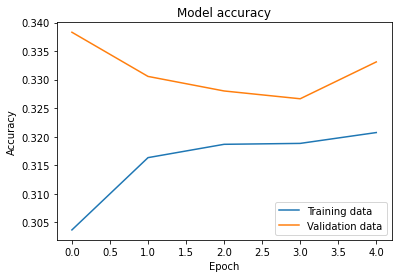

In [24]:
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
# plt.ylim(0, 1)
plt.legend(['Training data', 'Validation data'], loc='lower right')
plt.show()

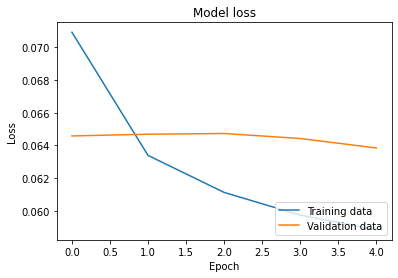

In [25]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
# plt.ylim(0, 1)
plt.legend(['Training data', 'Validation data'], loc='lower right')
plt.show()

In [26]:
filename = "2303"
x_test = np.load(filename+ "_data.npy" ).transpose()
y_test = np.load(filename+ "_labels.npy" )

print("Data shape: ", x_test.shape)
print("Labels shape: ", y_test.shape)
print("Duration (s): ", x_test.shape[0]*FRAME_LENGTH)

model.evaluate(x_test, y_test)

Data shape:  (2896, 264)
Labels shape:  (2896, 88)
Duration (s):  92.672
91/91 [==============================] - 0s 2ms/step - loss: 0.0429 - accuracy: 0.4541


[0.04293059930205345, 0.45407459139823914]

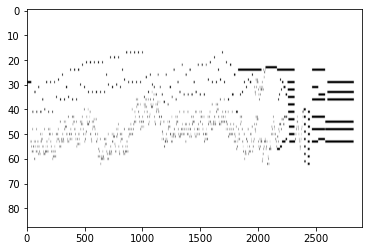

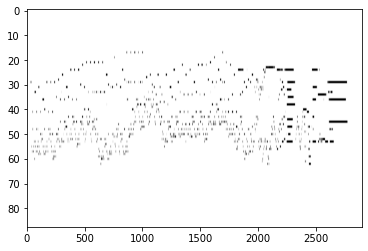

In [27]:
ground_truth = y_test.transpose()
prediction = model.predict(x_test).round().transpose()
"""
end_second = 10
end_index = round(end_second*FRAME_RATE)
ground_truth = ground_truth[:,0:end_index]
prediction = prediction[:,0:end_index]
"""
plt.figure()
plt.subplot()
plt.imshow(ground_truth,cmap='Greys',aspect='auto')

plt.figure()
plt.subplot()
plt.imshow(prediction,cmap='Greys',aspect='auto')

np.save(filename+"_prediction", prediction)

In [28]:
midi_pattern = data_to_midi(prediction)
midi.write_midifile(filename+'_midi.mid', midi_pattern)